In [20]:
import tensorflow as tf

#Save the list of files matching pattern, so it is only computed once
filenames = tf.train.match_filenames_once("./*.ipynb") 
count_num_files = tf.size(filenames)
dataset = tf.data.Dataset.from_tensor_slices(filenames)
reader = dataset.map(lambda filename: (filename, tf.read_file(filename)))

init = (tf.global_variables_initializer(), tf.local_variables_initializer())

iterator = reader.make_initializable_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
    sess.run(init)
    num_files = sess.run(count_num_files)
    sess.run(iterator.initializer)
    
    try:
        while True:
            filename, _ = sess.run(next_element)
            print(filename)
    except tf.errors.OutOfRangeError:
        pass       

print("num_files %d" % (num_files))

Instructions for updating:
Colocations handled automatically by placer.
b'./chapter_2.ipynb'
b'./chapter_3.ipynb'
b'./chapter_4.ipynb'
b'./chapter_5.ipynb'
b'./chapter_6.ipynb'
num_files 5


converged in 24


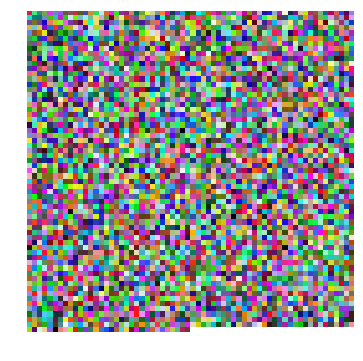

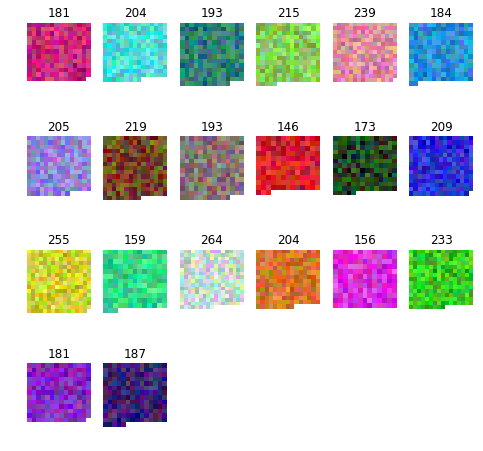

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

num_pixels = 4000
k = 20
max_iterations = 100

def initial_cluster_centroids(X, k):
    return X[0:k, :]
    
def assign_cluster(X, centroids):
    expanded_vectors = tf.expand_dims(X, 0) #shape [ 1 num_pixels  3]
    expanded_centroids = tf.expand_dims(centroids, 1) # shape [k 1 3]
    subst = expanded_vectors - expanded_centroids #shape [ k num_pixels  3]
    distances = tf.reduce_sum(tf.square(subst), 2) #shape [ k num_pixels]
    mins = tf.argmin(distances, 0) #shape [num_pixels] els indexes of clusters
    return mins

def recompute_centroids(X, Y):
    sums = tf.unsorted_segment_sum(X, Y, k)
    counts = tf.unsorted_segment_sum(tf.ones_like(X), Y, k)
    return sums/counts

X = np.array((
    np.random.randint(0, 256, num_pixels, dtype=np.int32), 
    np.random.randint(0, 256, num_pixels, dtype=np.int32), 
    np.random.randint(0, 256, num_pixels, dtype=np.int32)
)).T

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    centroids = initial_cluster_centroids(X, k)
    i = 0
    while i < max_iterations:
        i += 1
        Y = assign_cluster(X, centroids)
        old_centroids = tf.identity(centroids)
        centroids = tf.dtypes.cast(recompute_centroids(X, Y), tf.int32)
        converged = tf.reduce_all(tf.equal(centroids, old_centroids))
        if sess.run(converged):
            print("converged in %d" % (i))
            break
            
    Y = sess.run(assign_cluster(X, centroids))
    
x = [[] for _ in range(k)] 
for i,v in enumerate(Y):
    x[v].append(X[i].tolist())

s = math.ceil(math.sqrt(num_pixels))
xf = np.ndarray.flatten(X)
xf = np.append(xf, [255] * (s * s * 3 - len(xf))).reshape(s, s, 3)

fig_x = plt.figure(figsize=(6, 6))
fig_x.add_subplot(1, 1, 1)
plt.imshow(xf.astype(np.ubyte))
plt.axis('off')

fig=plt.figure(figsize=(8, 8))
rows = 4
for i in range(k):
    fig.add_subplot(rows, k // rows + 1, i + 1)
    s = math.ceil(math.sqrt(len(x[i])))
    xf = np.ndarray.flatten(np.array(x[i]))
    xf = np.append(xf, [255] * (s * s * 3 - len(xf))).reshape(s, s, 3)
    plt.title(len(x[i]))
    plt.imshow(xf.astype(np.ubyte))
    plt.axis('off')


plt.show()